In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,Subset
from torchinfo import summary
import matplotlib.pyplot as plt
from itertools import product
import numpy as np

In [10]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
train_data=datasets.FashionMNIST(root='./data',train=True,download=True,transform=transform)
test_data=datasets.FashionMNIST(root='./data',train=False,download=True,transform=transform)

In [11]:
train_indices=list(range(0,54000))
val_indices=list(range(54000,60000))
train_dataset=Subset(train_data,train_indices)
val_dataset=Subset(train_data,val_indices)

In [36]:
class AutoEncoder(nn.Module):
    def __init__(self,prob=0.1):
        super(AutoEncoder,self).__init__()

        self.encoder=nn.Sequential(
            nn.Conv2d(1,16,3,stride=2,padding=1),
            nn.ReLU(),
            nn.Dropout2d(prob),
            nn.Conv2d(16,32,3,stride=2,padding=1),
            nn.ReLU(),
            nn.Dropout2d(prob),
            nn.Conv2d(32,64,7),
            nn.ReLU()
        )

        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(64,32,7),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,3,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16,1,3,stride=2,padding=1,output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x=self.encoder(x)
        x=self.decoder(x)
        return x

In [37]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=AutoEncoder(prob=0.1).to(device)
summary(model,input_size=(1,28,28))

c:\Users\DEBARSHI\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 28, 28]               --
├─Sequential: 1-1                        [64, 1, 1]                --
│    └─Conv2d: 2-1                       [16, 14, 14]              160
│    └─ReLU: 2-2                         [16, 14, 14]              --
│    └─Dropout2d: 2-3                    [16, 14, 14]              --
│    └─Conv2d: 2-4                       [32, 7, 7]                4,640
│    └─ReLU: 2-5                         [32, 7, 7]                --
│    └─Dropout2d: 2-6                    [32, 7, 7]                --
│    └─Conv2d: 2-7                       [64, 1, 1]                100,416
│    └─ReLU: 2-8                         [64, 1, 1]                --
├─Sequential: 1-2                        [1, 28, 28]               --
│    └─ConvTranspose2d: 2-9              [32, 7, 7]                100,384
│    └─ReLU: 2-10                        [32, 7, 7]                --
│

Epoch 1/10 Loss: 0.09597492034126211
Epoch 2/10 Loss: 0.05127001475625568
Epoch 3/10 Loss: 0.04418336535052017
Epoch 4/10 Loss: 0.041073195447524385
Epoch 5/10 Loss: 0.03942620212943466
Epoch 6/10 Loss: 0.038333359974401966
Epoch 7/10 Loss: 0.03750249790262293
Epoch 8/10 Loss: 0.036886944543432304
Epoch 9/10 Loss: 0.03639524938000573
Epoch 10/10 Loss: 0.03598318111234241


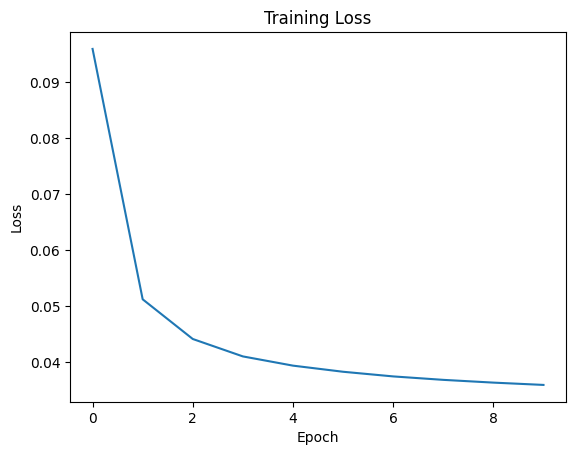

In [38]:
batch_size=32
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
val_loader=torch.utils.data.DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=False)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)


def train(model,train_loader,epochs=10):
    model.train()
    train_loss=[]
    for epoch in range(epochs):
        running_loss=0.0
        total_samples=0
        for data in train_loader:
            img,_=data
            img=img.to(device)
            optimizer.zero_grad()
            output=model(img)
            loss=criterion(output,img)
            loss.backward()
            optimizer.step()
            batch_size=img.size(0)
            total_samples+=batch_size
            running_loss+=loss.item()*img.size(0)

        epoch_loss=running_loss/total_samples
        train_loss.append(epoch_loss)
        print(f'Epoch {epoch+1}/{epochs} Loss: {epoch_loss}')

    return train_loss

train_loss = train(model, train_loader, epochs=10)
plt.plot(train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Epoch 1/10 Loss: 0.03414458506802718
Epoch 2/10 Loss: 0.03414458506802718
Epoch 3/10 Loss: 0.03414458506802718
Epoch 4/10 Loss: 0.03414458506802718
Epoch 5/10 Loss: 0.03414458506802718
Epoch 6/10 Loss: 0.03414458506802718
Epoch 7/10 Loss: 0.03414458506802718
Epoch 8/10 Loss: 0.03414458506802718
Epoch 9/10 Loss: 0.03414458506802718
Epoch 10/10 Loss: 0.03414458506802718


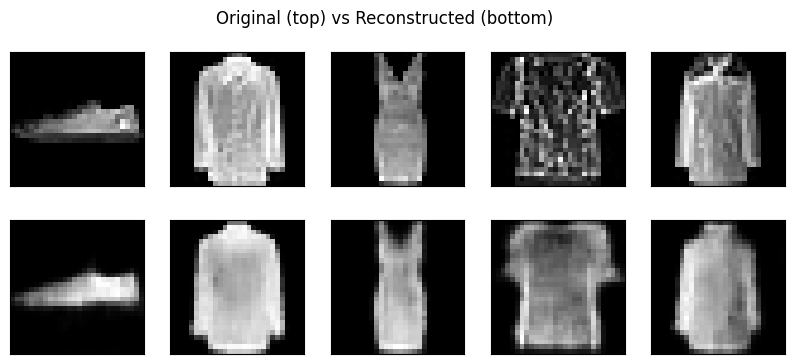

In [39]:
def test(model,val_loader,epochs=10):
    model.eval()
    val_loss=[]
    for epoch in range(epochs):
        running_loss=0.0
        total_samples=0
        with torch.no_grad():
            for data in val_loader:
                img,_=data
                img=img.to(device)
                output=model(img)
                loss=criterion(output,img)
                batch_size=img.size(0)
                total_samples+=batch_size
                running_loss+=loss.item()*img.size(0)

        epoch_loss=running_loss/total_samples
        val_loss.append(epoch_loss)
        print(f'Epoch {epoch+1}/{epochs} Loss: {epoch_loss}')

    
    with torch.no_grad():
        for data in val_loader:
            img, _ = data
            img = img.to(device)
            outputs = model(img)
            display_images(img, outputs)
            break

def display_images(original, reconstructed, num_images=5):
    original = original.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        ax = plt.subplot(2, num_images, i+1)
        plt.imshow(original[i].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(2, num_images, i+1 + num_images)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.suptitle('Original (top) vs Reconstructed (bottom)')
    plt.show()

test(model,val_loader)

## **Sparse Auto Encoder**

In [19]:
class SparseAutoEncoder(nn.Module):
    def __init__(self, input_dim=784, latent_dim=32, sparsity_target=0.1, sparsity_weight=0.1):
        super(SparseAutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Tanh()
        )

        self.sparsity_target = sparsity_target
        self.sparsity_weight = sparsity_weight
        self.latent_dim = latent_dim

    def kl_divergence(self, z):
        p_hat = torch.mean(z, dim=0)
        p = torch.full_like(p_hat, self.sparsity_target)
        kl = p * torch.log(p/p_hat) + (1-p) * torch.log((1-p)/(1-p_hat))
        return torch.sum(kl)

    def forward(self, x):
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

    def loss_function(self, x_recon, x, z):
        recon_loss = F.mse_loss(x_recon, x.view_as(x_recon), reduction='mean')
        kl_loss = self.kl_divergence(z)
        total_loss = recon_loss + self.sparsity_weight * kl_loss
        return total_loss, recon_loss, kl_loss

Epoch 1/10
Train Loss: 0.1249, Val Loss: 0.0107
Epoch 2/10
Train Loss: 0.0980, Val Loss: 0.0103
Epoch 3/10
Train Loss: 0.0943, Val Loss: 0.0099
Epoch 4/10
Train Loss: 0.0925, Val Loss: 0.0099
Epoch 5/10
Train Loss: 0.0911, Val Loss: 0.0098
Epoch 6/10
Train Loss: 0.0904, Val Loss: 0.0102
Epoch 7/10
Train Loss: 0.0896, Val Loss: 0.0102
Epoch 8/10
Train Loss: 0.0891, Val Loss: 0.0095
Epoch 9/10
Train Loss: 0.0887, Val Loss: 0.0096
Epoch 10/10
Train Loss: 0.0883, Val Loss: 0.0096


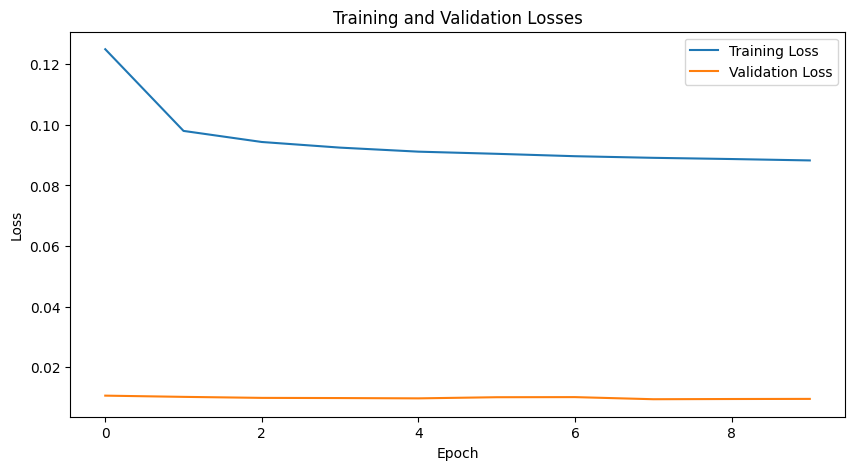

IndexError: index 1 is out of bounds for axis 0 with size 1

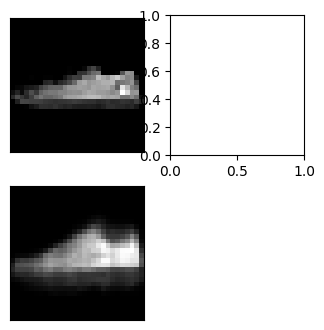

In [20]:
def train_model(model, train_loader, val_loader, epochs=10):
    device = next(model.parameters()).device
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            recon, z = model(data)
            loss, _, _ = model.loss_function(recon, data, z)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        
        val_loss = evaluate(model, val_loader)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses

def evaluate(model, data_loader):
    model.eval()
    total_loss = 0
    device = next(model.parameters()).device
    
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            recon, z = model(data)
            loss, _, _ = model.loss_function(recon, data, z)
            total_loss += loss.item()
    
    return total_loss / len(data_loader.dataset)

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def display_reconstructions(model, data_loader, num_images=5):
    model.eval()
    data, _ = next(iter(data_loader))
    data = data.to(device)
    
    with torch.no_grad():
        recon, _ = model(data)
    
    data = data.cpu().numpy()
    recon = recon.cpu().numpy()
    
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        ax = plt.subplot(2, num_images, i+1)
        plt.imshow(data[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(2, num_images, i+1 + num_images)
        plt.imshow(recon[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.suptitle('Original (top) vs Reconstructed (bottom)')
    plt.show()

if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader = train_dataset, val_dataset
    
    model = SparseAutoEncoder(
        input_dim=784,
        latent_dim=32,
        sparsity_target=0.1,
        sparsity_weight=0.2
    ).to(device)
    
    train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=10)
    
    plot_losses(train_losses, val_losses)
    display_reconstructions(model, val_loader)

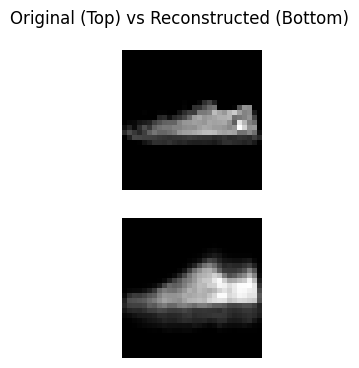

In [ ]:
batch = next(iter(val_loader))
data, _ = batch if isinstance(batch, (list, tuple)) else (batch, None) 
num_images = min(5, data.shape[0])
data = data[:num_images].to(device)  
with torch.no_grad():
    recon, _ = model(data)

data = data.cpu().numpy()
recon = recon.cpu().numpy()
plt.figure(figsize=(10, 4))
for i in range(num_images):
    
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(data[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
    
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(recon[i].reshape(28, 28), cmap="gray")
    ax.axis("off")

plt.suptitle("Original (Top) vs Reconstructed (Bottom)")
plt.show()


## **Noise Added Images**

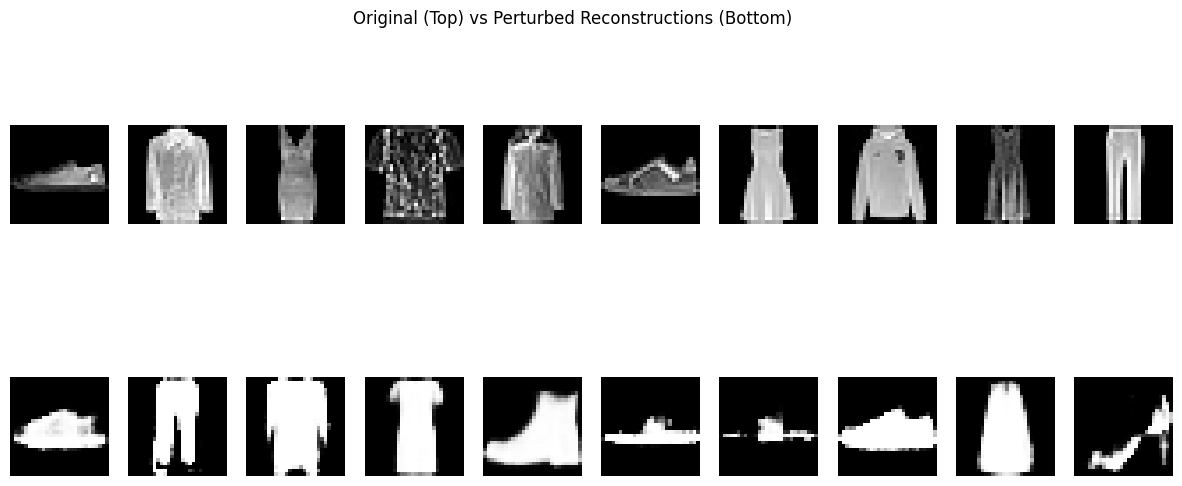

In [25]:
num_images = 10
images_collected = []

for batch in val_loader:
    data, _ = batch if isinstance(batch, (list, tuple)) else (batch, None)
    images_collected.append(data)
    if len(images_collected) * data.shape[0] >= num_images:
        break

data = torch.cat(images_collected, dim=0)[:num_images].to(device)
with torch.no_grad():
    _, z = model(data)
noise = torch.randn_like(z) * 0.1 
z_perturbed = z + noise

with torch.no_grad():
    recon_perturbed = model.decoder(z_perturbed)

data = data.cpu().numpy()
recon_perturbed = recon_perturbed.cpu().numpy()

plt.figure(figsize=(15, 6))
for i in range(num_images):
    
    ax = plt.subplot(2, num_images, i + 1)
    plt.imshow(data[i].reshape(28, 28), cmap="gray")
    ax.axis("off")  
    ax = plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(recon_perturbed[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
plt.suptitle("Original (Top) vs Perturbed Reconstructions (Bottom)")
plt.show()
